# TP 3

In [1]:
import torch
print("Cuda available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Cuda available:  True
Device:  cuda


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import random
from sklearn.utils import shuffle

In [3]:
data = pd.read_csv('HK_logret.csv.gz')
print("Shape", data.shape)
data.head(2)

Shape (4383, 1282)


,Unnamed: 0,0417.HK,2638.HK,0275.HK,0040.HK,0084.HK,0840.HK,0248.HK,0641.HK,0309.HK,...,0868.HK,0856.HK,1135.HK,0883.HK,0817.HK,1207.HK,3768.HK,0538.HK,0346.HK,8228.HK
0,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-05,0.0,NaN,NaN,-0.074115,-0.064532,NaN,NaN,0.0,NaN,...,NaN,NaN,-0.026451,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.set_index('Unnamed: 0', inplace=True)
data.index.name = "Date"
data.index = pd.to_datetime(data.index)
data.head(2)

,0417.HK,2638.HK,0275.HK,0040.HK,0084.HK,0840.HK,0248.HK,0641.HK,0309.HK,1202.HK,...,0868.HK,0856.HK,1135.HK,0883.HK,0817.HK,1207.HK,3768.HK,0538.HK,0346.HK,8228.HK
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.0,NaN,NaN,-0.074115,-0.064532,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,-0.026451,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = data.loc[data.index > '2010-01-01'].copy()
df.head(1)

,0417.HK,2638.HK,0275.HK,0040.HK,0084.HK,0840.HK,0248.HK,0641.HK,0309.HK,1202.HK,...,0868.HK,0856.HK,1135.HK,0883.HK,0817.HK,1207.HK,3768.HK,0538.HK,0346.HK,8228.HK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.004338,NaN,0.0,-0.030771,0.020831,-0.022223,-0.075878,0.007823,-0.020619,0.054394,...,0.002842,-0.010641,NaN,0.0,0.003643,0.0,NaN,0.023811,0.083881,-0.02927


<Axes: xlabel='Date', ylabel='0040.HK'>

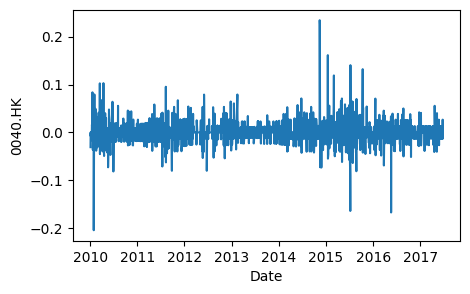

In [6]:
plt.figure(figsize=(5, 3))
sns.lineplot(data=df, x='Date', y='0040.HK')

In [7]:
def largest_continuous_non_nan_series(column):
    max_len = 0
    max_start = 0
    current_len = 0
    current_start = 0
    in_series = False
    
    for i in range(len(column)):
        if not pd.isna(column.iloc[i]):
            if not in_series:
                current_start = i
                in_series = True
            current_len += 1
        else:
            if in_series:
                in_series = False
                if current_len > max_len:
                    max_len = current_len
                    max_start = current_start
                current_len = 0
    if in_series and current_len > max_len:
        max_len = current_len
        max_start = current_start
    return column.iloc[max_start:max_start+max_len]

In [8]:
dict_series = {col : largest_continuous_non_nan_series(df[col]) for col in df.columns}

In [9]:
len(dict_series.keys())

1281

Taking only columns that work and checking if there are nan values in the dataset.

In [10]:
there_are_nans = False
T = 252

columns_to_drop = []
for key in dict_series.keys():
    if len(dict_series[key]) < 5*T:
        columns_to_drop.append(key)
        continue
    if dict_series[key].isna().any():
        there_are_nans = True
        break
    
print("There are nans: ", there_are_nans)
print("Columns to drop: ", len(columns_to_drop))

for col in columns_to_drop:
    del dict_series[col]    

There are nans:  False
Columns to drop:  304


Here on forward we will use only one asset

In [11]:
key_1 = list(dict_series.keys())[0]
dict_series = {key_1 : dict_series[key_1] }

Building a random sampler

In [12]:
def get_arrays_of_rets(dic : dict, batch_size : int, T : int) -> list:
    assets = list(dic.keys())
    list_of_rets = []
    for i in range(batch_size):
        asset = random.choice(assets)
        j = random.randint(0, len(dic[asset]) - T)
        list_of_rets.append(dic[asset].iloc[j:j+T].values)
    return list_of_rets

<Axes: xlabel='Date', ylabel='0417.HK'>

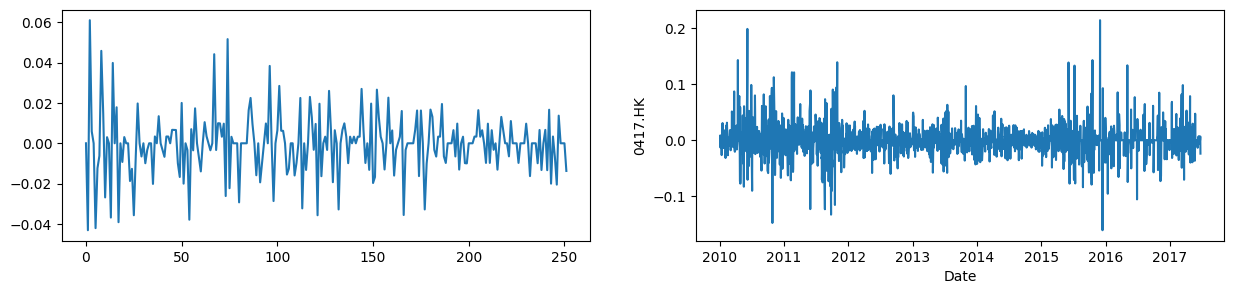

In [13]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.lineplot(data=get_arrays_of_rets(dict_series, 1, T)[0])
plt.subplot(1, 2, 2)
sns.lineplot(data=dict_series[list(dict_series.keys())[0]])

### Generator

In [14]:
class Generator(nn.Module):
    def __init__(self, dim_output, dim_noise, hidden_layers = [], use_bias = False):
        super(Generator, self).__init__()
        if hidden_layers == []:
            hidden_layers = [dim_noise]
            
        num_hidden_layers = len(hidden_layers)
        
        layers = []
        # INput layer
        layers.append(nn.Linear(dim_noise, hidden_layers[0], bias = use_bias))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.BatchNorm1d(hidden_layers[0]))
        
        for i in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1], bias = use_bias))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.BatchNorm1d(hidden_layers[i + 1]))
            
        #Output layers
        layers.append(nn.Linear(hidden_layers[-1], dim_output, bias = use_bias))
        layers.append(nn.Tanh())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [15]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, T, hidden_layers=None, activation="leakyrelu", use_bias=False):
        super(Discriminator, self).__init__()
        if hidden_layers is None:
            # Default hidden layer sizes based on T
            hidden_layers = [T, T // 2, T // 4]

        layers = []

        # Input layer
        layers.append(nn.Linear(T, hidden_layers[0], bias=use_bias))
        if activation == "leakyrelu":
            layers.append(nn.LeakyReLU(0.2))
        elif activation == "relu":
            layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1], bias=use_bias))
            if activation == "leakyrelu":
                layers.append(nn.LeakyReLU(0.2))
            elif activation == "relu":
                layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], 1, bias=use_bias))
        layers.append(nn.Sigmoid())

        # Register the layers as a Sequential module
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [16]:
input_gen = 252 * 2
hidden_layers_gen = [512, 384, 384, 256]
output_gen = 252
bias_gen = False

gen = Generator(output_gen, input_gen, hidden_layers_gen, bias_gen)
summary(gen)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       258,048
│    └─LeakyReLU: 2-2                    --
│    └─BatchNorm1d: 2-3                  1,024
│    └─Linear: 2-4                       196,608
│    └─LeakyReLU: 2-5                    --
│    └─BatchNorm1d: 2-6                  768
│    └─Linear: 2-7                       147,456
│    └─LeakyReLU: 2-8                    --
│    └─BatchNorm1d: 2-9                  768
│    └─Linear: 2-10                      98,304
│    └─LeakyReLU: 2-11                   --
│    └─BatchNorm1d: 2-12                 512
│    └─Linear: 2-13                      64,512
│    └─Tanh: 2-14                        --
Total params: 768,000
Trainable params: 768,000
Non-trainable params: 0

In [17]:
input_disc = 252
hidden_layers_disc = [256, 128, 128, 64]
bias_disc = False

disc = Discriminator(input_disc, hidden_layers_disc, "leakyrelu", bias_disc)
summary(disc)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       64,512
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       32,768
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       16,384
│    └─LeakyReLU: 2-6                    --
│    └─Linear: 2-7                       8,192
│    └─LeakyReLU: 2-8                    --
│    └─Linear: 2-9                       64
│    └─Sigmoid: 2-10                     --
Total params: 121,920
Trainable params: 121,920
Non-trainable params: 0

In [18]:
# Custom Dataset Class
class GANTrainingDataset(Dataset):
    def __init__(self, dic, T, step = 1):
        """
        Args:
            dic: Dictionary of assets with their returns (as numpy arrays).
            T: Length of the time window for real samples.
        """
        self.samples = []
        for asset in dic.keys():
            rets = dic[asset].values
            for i in range(0, len(rets) - T, step):
                self.samples.append(rets[i:i+T])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)   

### Training

In [19]:
# GAN Training Loop
def train_gan(generator, discriminator, input_gen, 
                opt_generator, opt_discriminator, 
                criterion, num_epochs, data_loader,
                losses_discriminator = [], losses_generator = []):
    
    real_label = 1.0
    fake_label = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        
        loss_discriminator_add = 0.0
        loss_generator_add = 0.0
        size_dis = 0
        size_gen = 0
        
        for real_data in data_loader:
            batch_size = real_data.size(0)
            real_data = real_data.to(device)
            
            # Generate fake data
            noise = torch.randn(batch_size, input_gen, device=device)
            fake_data = generator(noise)
            
            # Create mix data
            mixed_data = torch.cat((real_data, fake_data), 0)
            labels = torch.cat(
                (
                    torch.full((batch_size, 1), real_label, dtype = torch.float, device=device),
                    torch.full((batch_size, 1), fake_label, dtype = torch.float, device=device)
                ),
                dim=0
            )
            
            #Shuffle
            indices = torch.randperm(mixed_data.size(0)) #random permutation
            mixed_data = mixed_data[indices]
            labels = labels[indices]
            
            # Train discriminator
            size_dis += batch_size * 2
            opt_discriminator.zero_grad()
            output = discriminator(mixed_data)
            loss_discriminator = criterion(output, labels)
            loss_discriminator.backward()
            opt_discriminator.step()
            
            # Train generator
            size_gen += batch_size
            opt_generator.zero_grad()
            noise = torch.randn(batch_size, input_gen, device=device)
            fake_data = generator(noise)
            target_labels = torch.full((batch_size, 1), real_label, device=device, dtype=torch.float32)
            output = discriminator(fake_data)
            loss_generator = criterion(output, target_labels)
            loss_generator.backward()
            opt_generator.step()
            
            # Adding losses
            loss_discriminator_add += loss_discriminator.item()
            loss_generator_add += loss_generator.item()            
              
            
        epoch_loss_dis = loss_discriminator.item() / size_dis
        epoch_loss_gen = loss_generator.item() / size_gen
            
        losses_discriminator.append(epoch_loss_dis)
        losses_generator.append(epoch_loss_gen)   
            
        print(f"Loss D: {round(epoch_loss_dis, 9)}, Loss G: {round(epoch_loss_gen, 9)}")
        
        

In [20]:
batch_size = 32
T = 252
dim_noise = 252 * 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loader
dataset = GANTrainingDataset(dict_series, T, step = 6)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print("Dataset Length: ", len(dataset))
print("Data Loader Length: ", len(data_loader))

# Generator
input_gen = dim_noise
hidden_layers_gen = [512, 400, 384, 256, 252]
output_gen = T
bias_gen = True
gen = Generator(output_gen, input_gen, hidden_layers_gen, bias_gen)

# Discriminator
input_disc = T
hidden_layers_disc = [256, 128, 64, 32, 16]
bias_disc = True
disc = Discriminator(input_disc, hidden_layers_disc, "leakyrelu", bias_disc)

# Optimizers
INIT_LR = 1e-4
opt_discriminator = optim.Adam(disc.parameters(), lr=INIT_LR/10, betas=(0.5, 0.999))
opt_gan = optim.Adam(gen.parameters(), lr=INIT_LR, betas=(0.5, 0.999))
criterion = nn.BCELoss()

Dataset Length:  266
Data Loader Length:  8


In [21]:

if os.path.exists("model.pth"):
    print("File model.pth exists.")
    checkpoint = torch.load("model.pth", weights_only=True)
    gen.load_state_dict(checkpoint['generator'])
    disc.load_state_dict(checkpoint['discriminator'])
    
    gen.to(device)
    disc.to(device)
    
else:
    print("File model.pth does not exist.")

    num_epochs = 500

    losses_dis, losses_gen = [], []

    try:
        train_gan(
            generator=gen.to(device),
            discriminator=disc.to(device),
            input_gen=dim_noise,
            opt_generator=opt_gan,
            opt_discriminator=opt_discriminator,
            criterion=criterion,
            num_epochs=num_epochs,
            data_loader=data_loader,
            losses_discriminator=losses_dis,
            losses_generator=losses_gen
        )
        
    except KeyboardInterrupt as e:
        print("Ending training abruptly")
    
    finally:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.lineplot(data=losses_dis, label="Loss dis")
        plt.subplot(1, 2, 2)
        sns.lineplot(data=losses_gen, label="Loss gen")

File model.pth exists.


In [22]:
def get_fake_data(generator, n, dim_noise):
    generator.eval()
    noise = torch.randn(n, dim_noise, device=device)
    with torch.no_grad():
        output = generator(noise).detach().cpu().numpy()
    return output

Is fake data fake?: 0.49935388565063477
Is real data real?: 0.49932748079299927


C:\Users\Marti\AppData\Local\Temp\ipykernel_42664\663468016.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  print("Is real data real?:", disc(torch.tensor(real_data, dtype=torch.float32).to(device) ).item())


Text(0.5, 1.0, 'Real Data')

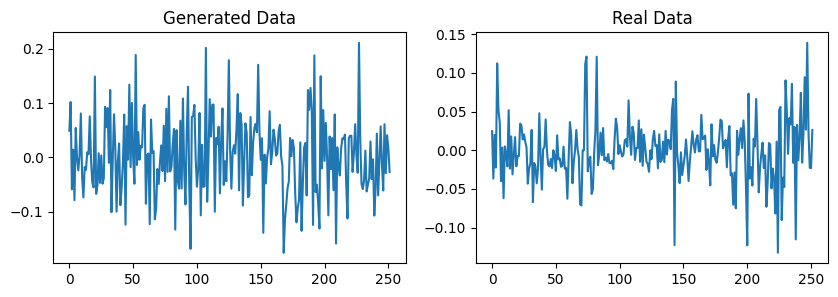

In [23]:
# Set the generator to evaluation mode
gen.eval()
disc.eval()

# Example of fake data
fake_data = get_fake_data(gen, 1, dim_noise)
    
print("Is fake data fake?:", disc(torch.tensor(fake_data, dtype=torch.float32).to(device) ).item())    

# Example of real data
real_data = get_arrays_of_rets(dict_series, 1, T)

print("Is real data real?:", disc(torch.tensor(real_data, dtype=torch.float32).to(device) ).item())

# Plot the generated data
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.lineplot(data=fake_data[0])
plt.title("Generated Data")
plt.subplot(1, 2, 2)
sns.lineplot(data=real_data[0])
plt.title("Real Data")

Saving the model

In [24]:
torch.save({
    'generator' : gen.state_dict(),
    'discriminator' : disc.state_dict()
}, "model.pth")

## Question 5

Generate 3 vectors, and display their returns time series, while also the acummulated sums.


In [25]:
torch.manual_seed(43)

fake_data = get_fake_data(gen, 3, dim_noise)

fake_data.shape

(3, 252)

In [26]:
acummulated_sums = np.cumsum(fake_data, axis=0) + 100

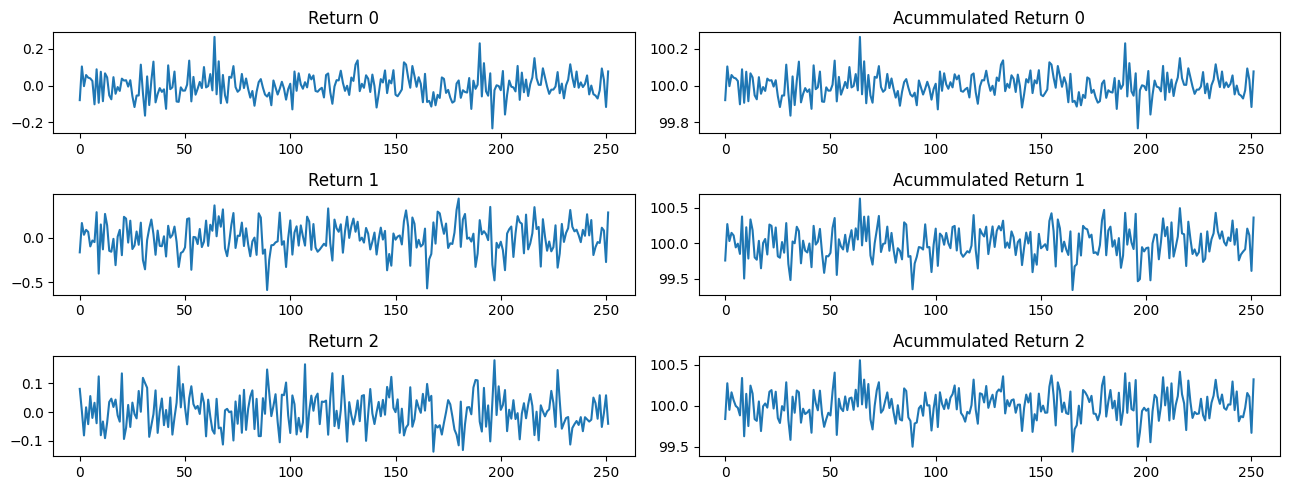

In [27]:
plt.figure(figsize=(13, 5))
for i in range(3):
    plt.subplot(3, 2, i*2 + 1)
    plt.title(f"Return {i}")
    sns.lineplot(data=fake_data[i])
    plt.subplot(3, 2, i*2 + 2)
    sns.lineplot(data=acummulated_sums[i])
    plt.title(f"Acummulated Return {i}")
plt.tight_layout()
plt.show()
    

They are different but they also have similarities between them.However, the most impactful aspect is that they dont retain the charascetristics of a real stock market time series. For example, there is no trend

### Test faits stylises

1000 artificial time series

In [28]:
series = get_fake_data(gen, 1000, dim_noise)
series.shape

(1000, 252)

In [29]:
returns = series

In [30]:
flattened_returns = np.abs(returns.flatten())

volatility = np.std(flattened_returns)

flattened_returns.shape

(252000,)

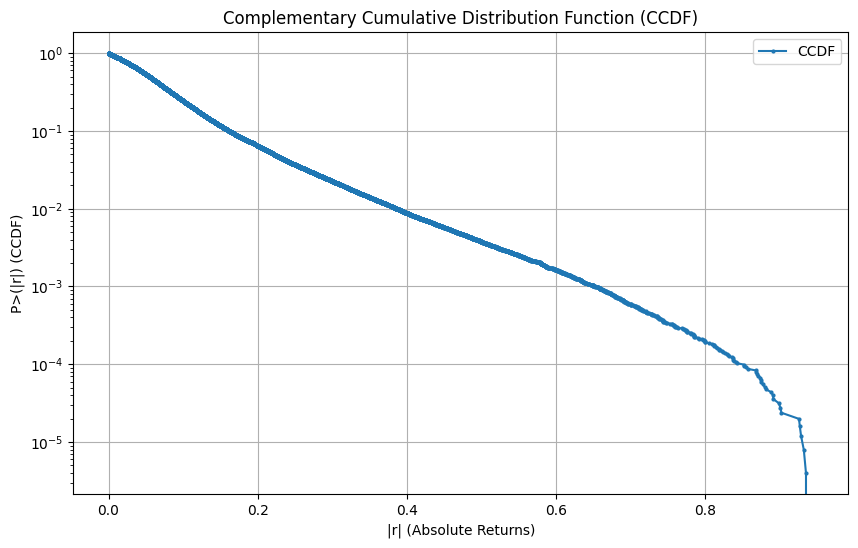

In [31]:
sorted_returns = np.sort(flattened_returns)
ccdf = 1.0 - np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

# Plot on lin-log scale
plt.figure(figsize=(10, 6))
plt.plot(sorted_returns, ccdf, marker='o', linestyle='-', markersize=2, label='CCDF')
plt.yscale('log')  # Logarithmic scale for CCDF
plt.xlabel('|r| (Absolute Returns)')
plt.ylabel('P>(|r|) (CCDF)')
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.legend()
plt.grid(True)
plt.show()


### Example fat tails for normal case

The normal will have the same volatility or standard deviation that the one from the data generated

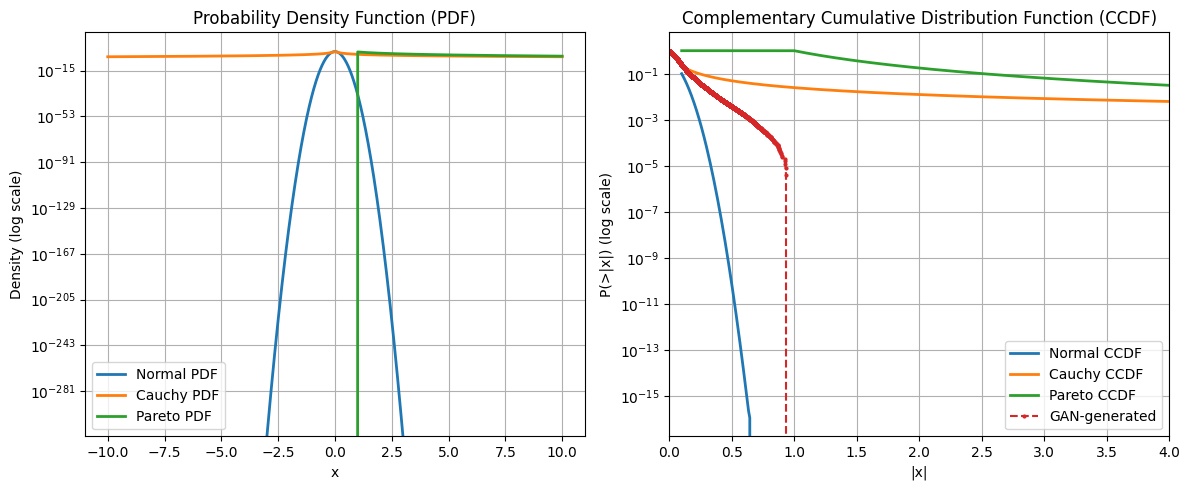

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy, pareto

# Generate data
x = np.linspace(-10, 10, 1000)  # Range for PDF
x_positive = np.linspace(0.1, 10, 1000)  # Positive range for CCDF

# Normal distribution
normal_pdf = norm.pdf(x, loc=0, scale=volatility)
normal_ccdf = 1 - norm.cdf(x_positive, loc=0, scale=volatility)

# Cauchy distribution (heavy-tailed)
cauchy_pdf = cauchy.pdf(x, loc=0, scale=volatility)
cauchy_ccdf = 1 - cauchy.cdf(x_positive, loc=0, scale=volatility)

# Pareto distribution (heavy-tailed)
pareto_b = 2.5  # Shape parameter for Pareto (controls tail heaviness)
pareto_pdf = pareto.pdf(x_positive, b=pareto_b)
pareto_ccdf = 1 - pareto.cdf(x_positive, b=pareto_b)

# Plot PDFs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, normal_pdf, label='Normal PDF', lw=2)
plt.plot(x, cauchy_pdf, label='Cauchy PDF', lw=2)
plt.plot(x_positive, pareto_pdf, label='Pareto PDF', lw=2)
plt.yscale('log')  # Log scale for PDF comparison
plt.title('Probability Density Function (PDF)')
plt.xlabel('x')
plt.ylabel('Density (log scale)')
plt.legend()
plt.grid(True)

# Plot CCDFs
plt.subplot(1, 2, 2)
plt.plot(x_positive, normal_ccdf, label='Normal CCDF', lw=2)
plt.plot(x_positive, cauchy_ccdf, label='Cauchy CCDF', lw=2)
plt.plot(x_positive, pareto_ccdf, label='Pareto CCDF', lw=2)
plt.plot(sorted_returns, ccdf, marker='o', linestyle='--', markersize=2, label='GAN-generated')
plt.yscale('log')  # Log scale for CCDF
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.xlabel('|x|')
plt.xlim(0,4)
plt.ylabel('P(>|x|) (log scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Comparing with the other distributions, we can say that it has a tail more heavier than the one from the normal case, however it is not perfect like the ones from the cauchy distribution that is polinomial.

### Test the autocorrelation

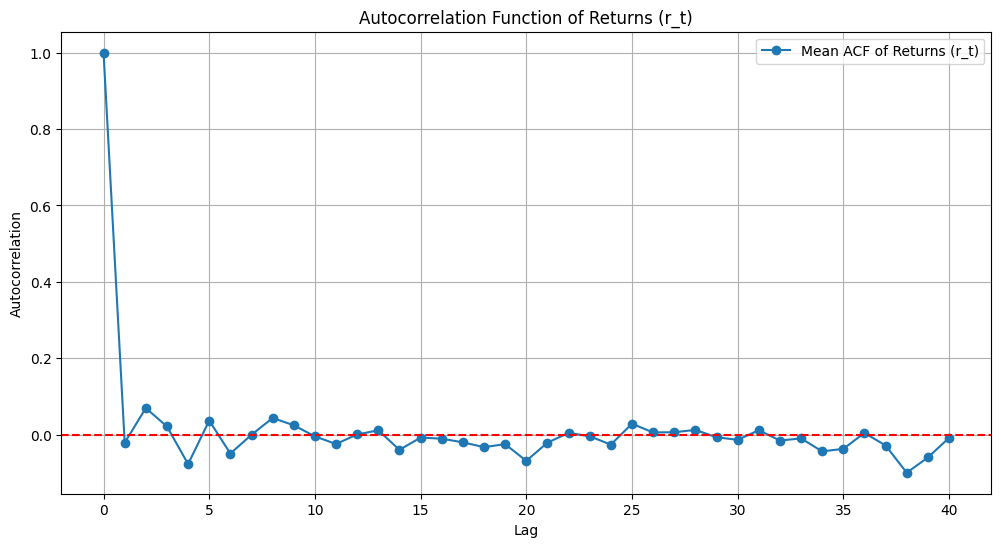

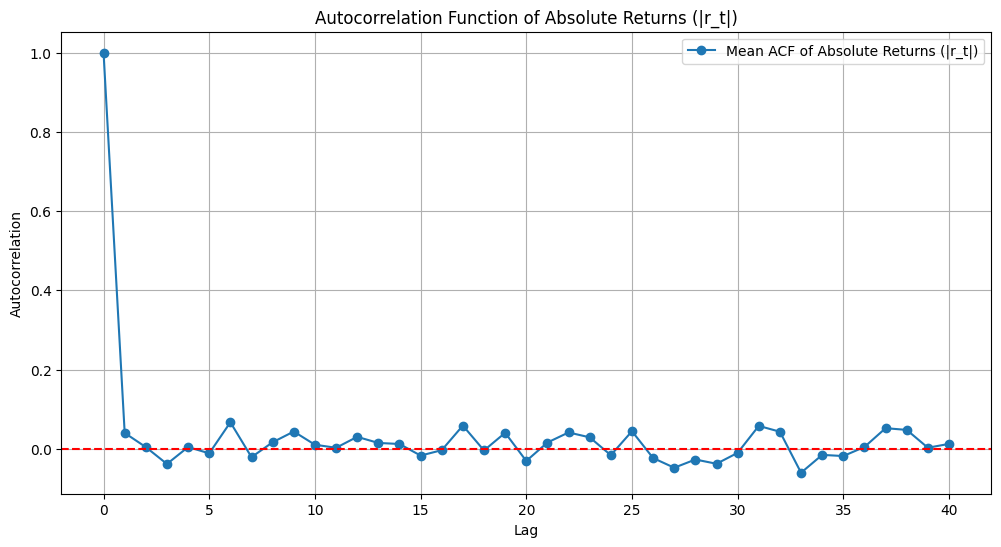

C:\Users\Marti\AppData\Local\Temp\ipykernel_42664\3743521901.py:46: RuntimeWarning: invalid value encountered in log
  log_acf = np.log(mean_acf_abs_returns[1:])


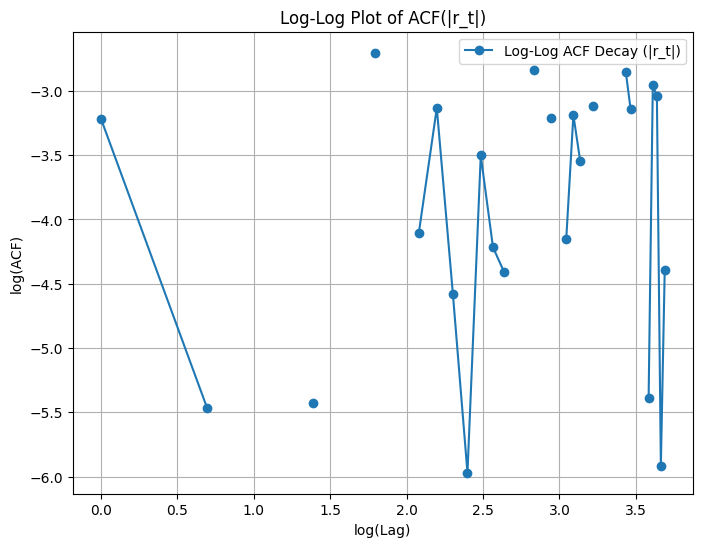

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

abs_returns = np.abs(returns)

max_lag = 40
acf_returns = []
for series in returns:
    acf_values = acf(series, nlags = max_lag, fft = True)
    acf_returns.append(acf_values)
    
mean_acf_returns = np.mean(acf_returns, axis= 0)

# Plot mean ACF of r_t
plt.figure(figsize=(12, 6))
plt.plot(range(max_lag + 1), mean_acf_returns, marker='o', label='Mean ACF of Returns (r_t)')
plt.axhline(0, color='red', linestyle='--')
plt.title('Autocorrelation Function of Returns (r_t)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

# 4. Aggregate ACF for |r_t| (absolute returns)
acf_abs_returns = []
for series in abs_returns:
    acf_values = acf(series, nlags=max_lag, fft=True)
    acf_abs_returns.append(acf_values)

mean_acf_abs_returns = np.mean(acf_abs_returns, axis=0)

# Plot mean ACF of |r_t|
plt.figure(figsize=(12, 6))
plt.plot(range(max_lag + 1), mean_acf_abs_returns, marker='o', label='Mean ACF of Absolute Returns (|r_t|)')
plt.axhline(0, color='red', linestyle='--')
plt.title('Autocorrelation Function of Absolute Returns (|r_t|)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

# 5. Log-log plot of ACF decay for |r_t|
log_lags = np.log(range(1, max_lag + 1))
log_acf = np.log(mean_acf_abs_returns[1:])

plt.figure(figsize=(8, 6))
plt.plot(log_lags, log_acf, marker='o', label='Log-Log ACF Decay (|r_t|)')
plt.title('Log-Log Plot of ACF(|r_t|)')
plt.xlabel('log(Lag)')
plt.ylabel('log(ACF)')
plt.grid(True)
plt.legend()
plt.show()

We can see that there is no linear correlation with respect their past values.

But the absolute value serie of the returns have a autocorrelation for almost all the values near to zero, so we can sa that the serie doesn't have long term memory.

# Dense networks less naives.

In [34]:
batch_size = 32
T = 252
dim_noise = 252 * 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loader
dataset = GANTrainingDataset(dict_series, T, step = 6)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print("Dataset Length: ", len(dataset))
print("Data Loader Length: ", len(data_loader))

# Generator
input_gen = dim_noise
hidden_layers_gen = [512, 400, 384, 256, 252]
output_gen = T
bias_gen = False
gen2 = Generator(output_gen, input_gen, hidden_layers_gen, bias_gen)

# Discriminator
input_disc = T
hidden_layers_disc = [256, 128, 64, 32, 16]
bias_disc = True
disc2 = Discriminator(input_disc, hidden_layers_disc, "leakyrelu", bias_disc)

# Optimizers
INIT_LR = 1e-4
opt_discriminator = optim.Adam(disc.parameters(), lr=INIT_LR/10, betas=(0.5, 0.999))
opt_gan = optim.Adam(gen.parameters(), lr=INIT_LR, betas=(0.5, 0.999))
criterion = nn.BCELoss()

Dataset Length:  266
Data Loader Length:  8


In [35]:
if os.path.exists("model2.pth"):
    print("File model2.pth exists.")
    checkpoint = torch.load("model2.pth", weights_only=True)
    gen2.load_state_dict(checkpoint['generator'])
    disc2.load_state_dict(checkpoint['discriminator'])
    
    gen2.to(device)
    disc2.to(device)
    
else:
    print("File model2.pth does not exist.")

    num_epochs = 500

    losses_dis, losses_gen = [], []

    try:
        train_gan(
            generator=gen.to(device),
            discriminator=disc.to(device),
            input_gen=dim_noise,
            opt_generator=opt_gan,
            opt_discriminator=opt_discriminator,
            criterion=criterion,
            num_epochs=num_epochs,
            data_loader=data_loader,
            losses_discriminator=losses_dis,
            losses_generator=losses_gen
        )
        
    except KeyboardInterrupt as e:
        print("Ending training abruptly")
    
    finally:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.lineplot(data=losses_dis, label="Loss dis")
        plt.subplot(1, 2, 2)
        sns.lineplot(data=losses_gen, label="Loss gen")

File model2.pth exists.


Is fake data fake?: 0.4999791979789734
Is real data real?: 0.4993413984775543


Text(0.5, 1.0, 'Real Data')

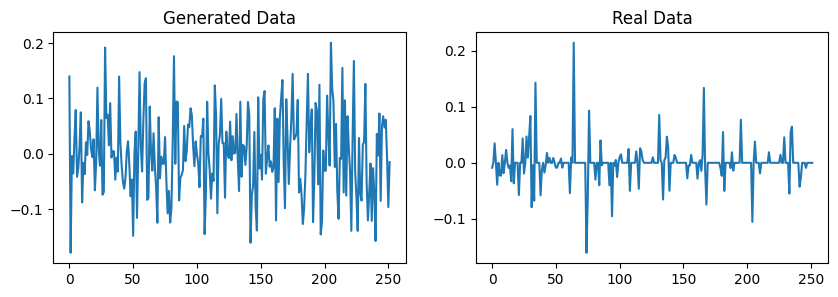

In [36]:
# Set the generator to evaluation mode
gen2.eval()
disc2.eval()

# Example of fake data
fake_data = get_fake_data(gen2, 1, dim_noise)
    
print("Is fake data fake?:", disc2(torch.tensor(fake_data, dtype=torch.float32).to(device) ).item())    

# Example of real data
real_data = get_arrays_of_rets(dict_series, 1, T)

print("Is real data real?:", disc(torch.tensor(real_data, dtype=torch.float32).to(device) ).item())

# Plot the generated data
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.lineplot(data=fake_data[0])
plt.title("Generated Data")
plt.subplot(1, 2, 2)
sns.lineplot(data=real_data[0])
plt.title("Real Data")

In [37]:
torch.save({
    'generator' : gen2.state_dict(),
    'discriminator' : disc2.state_dict()
}, "model2.pth")   

In [38]:
torch.manual_seed(43)

fake_data2 = get_fake_data(gen2, 4, dim_noise)
fake_data2.shape

(4, 252)

In [39]:
acummulated_sums2 = np.cumsum(fake_data2, axis=0)

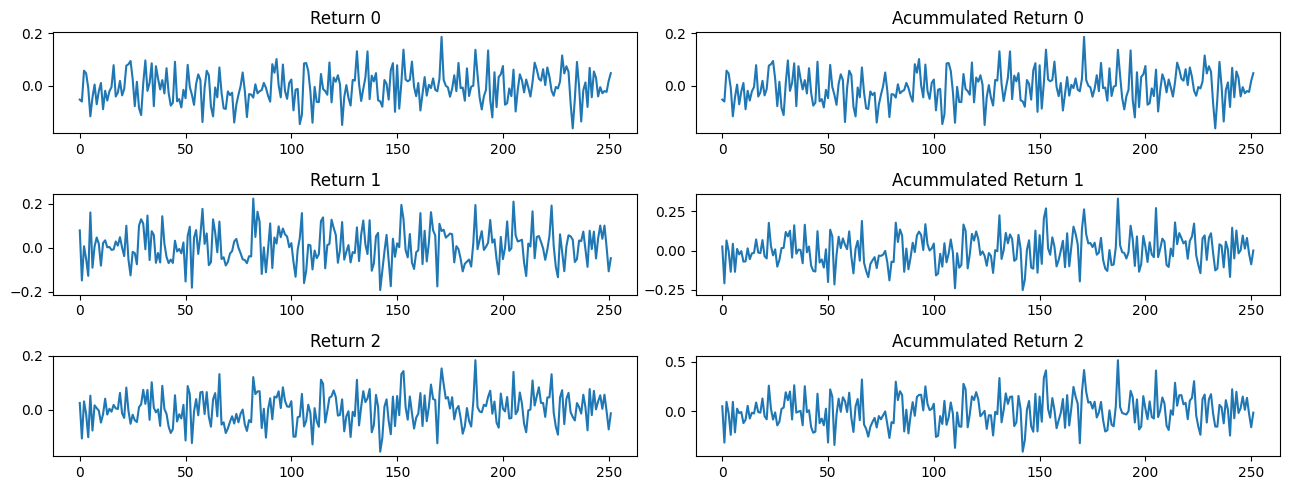

In [40]:
plt.figure(figsize=(13, 5))
for i in range(3):
    plt.subplot(3, 2, i*2 + 1)
    plt.title(f"Return {i}")
    sns.lineplot(data=fake_data2[i])
    plt.subplot(3, 2, i*2 + 2)
    sns.lineplot(data=acummulated_sums2[i])
    plt.title(f"Acummulated Return {i}")
plt.tight_layout()
plt.show()
    

They are still similar between them. there are some little variations.

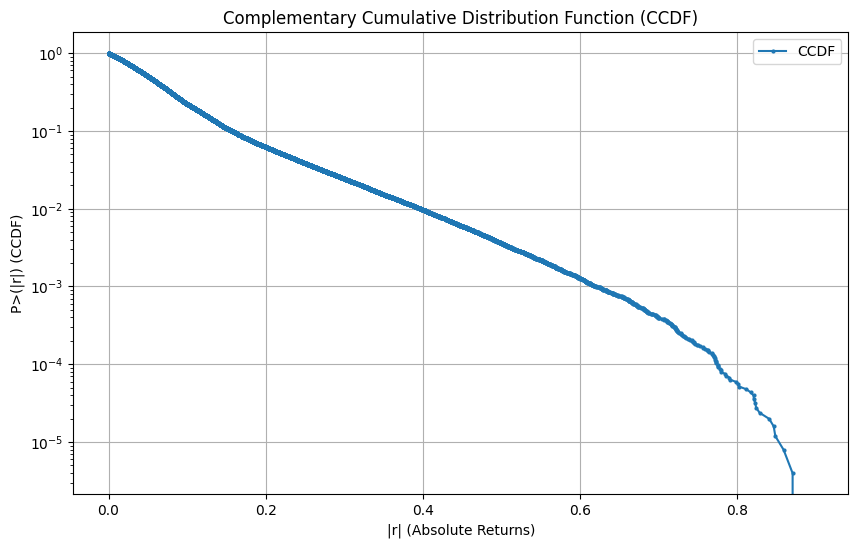

In [41]:
series2 = get_fake_data(gen2, 1000, dim_noise)
returns2 = series2
flattened_returns2 = np.abs(returns2.flatten())
volatility2 = np.std(flattened_returns2)
sorted_returns2 = np.sort(flattened_returns2)
ccdf2 = 1.0 - np.arange(1, len(sorted_returns2) + 1) / len(sorted_returns2)

# Plot on lin-log scale
plt.figure(figsize=(10, 6))
plt.plot(sorted_returns2, ccdf2, marker='o', linestyle='-', markersize=2, label='CCDF')
plt.yscale('log')  # Logarithmic scale for CCDF
plt.xlabel('|r| (Absolute Returns)')
plt.ylabel('P>(|r|) (CCDF)')
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.legend()
plt.grid(True)
plt.show()


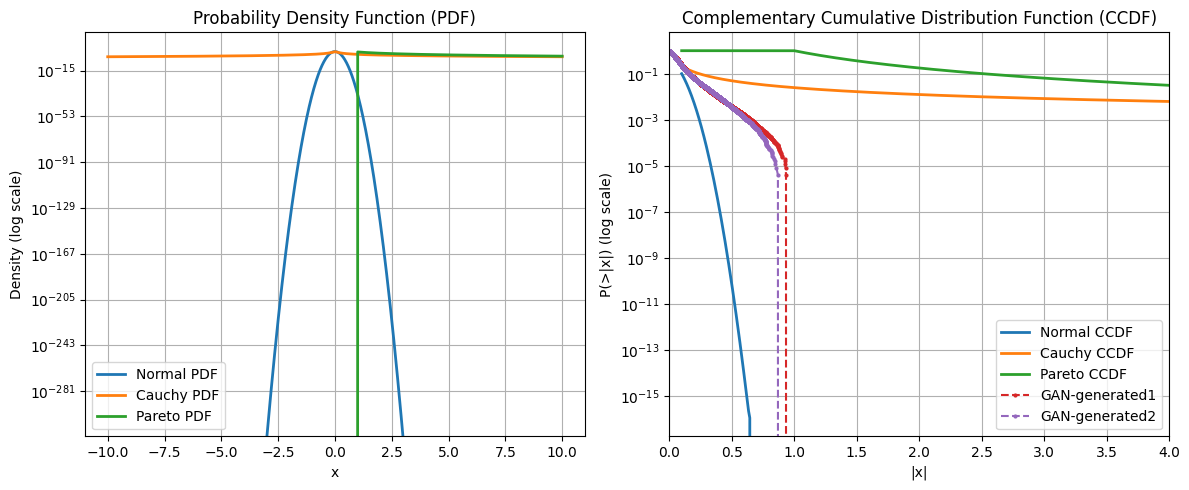

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy, pareto

# Generate data
x = np.linspace(-10, 10, 1000)  # Range for PDF
x_positive = np.linspace(0.1, 10, 1000)  # Positive range for CCDF

# Normal distribution
normal_pdf = norm.pdf(x, loc=0, scale=volatility)
normal_ccdf = 1 - norm.cdf(x_positive, loc=0, scale=volatility)

# Cauchy distribution (heavy-tailed)
cauchy_pdf = cauchy.pdf(x, loc=0, scale=volatility)
cauchy_ccdf = 1 - cauchy.cdf(x_positive, loc=0, scale=volatility)

# Pareto distribution (heavy-tailed)
pareto_b = 2.5  # Shape parameter for Pareto (controls tail heaviness)
pareto_pdf = pareto.pdf(x_positive, b=pareto_b)
pareto_ccdf = 1 - pareto.cdf(x_positive, b=pareto_b)

# Plot PDFs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, normal_pdf, label='Normal PDF', lw=2)
plt.plot(x, cauchy_pdf, label='Cauchy PDF', lw=2)
plt.plot(x_positive, pareto_pdf, label='Pareto PDF', lw=2)
plt.yscale('log')  # Log scale for PDF comparison
plt.title('Probability Density Function (PDF)')
plt.xlabel('x')
plt.ylabel('Density (log scale)')
plt.legend()
plt.grid(True)

# Plot CCDFs
plt.subplot(1, 2, 2)
plt.plot(x_positive, normal_ccdf, label='Normal CCDF', lw=2)
plt.plot(x_positive, cauchy_ccdf, label='Cauchy CCDF', lw=2)
plt.plot(x_positive, pareto_ccdf, label='Pareto CCDF', lw=2)
plt.plot(sorted_returns, ccdf, marker='o', linestyle='--', markersize=2, label='GAN-generated1')
plt.plot(sorted_returns2, ccdf, marker='o', linestyle='--', markersize=2, label='GAN-generated2')
plt.yscale('log')  # Log scale for CCDF
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.xlabel('|x|')
plt.xlim(0,4)
plt.ylabel('P(>|x|) (log scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


It is heavy tailed but very similar to the previous model.

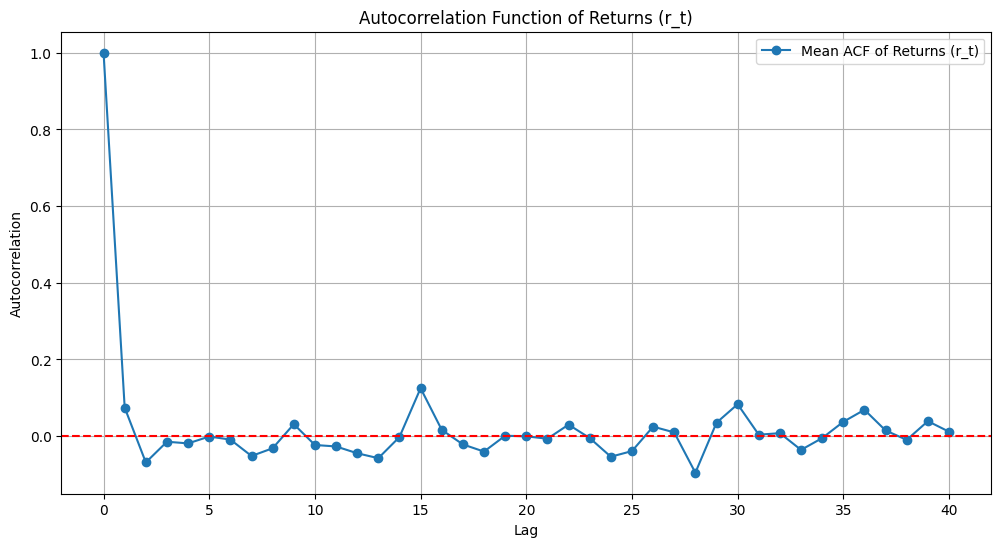

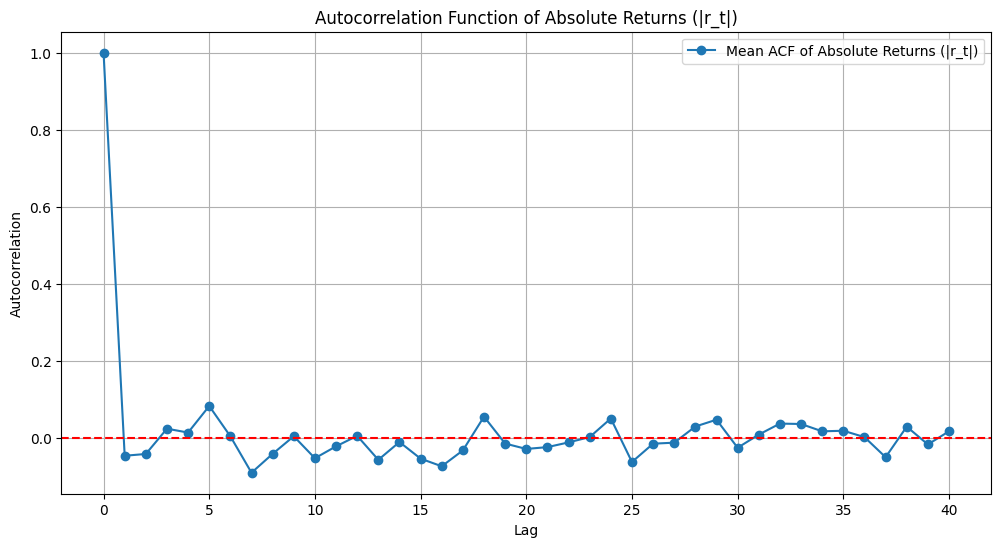

C:\Users\Marti\AppData\Local\Temp\ipykernel_42664\3747671123.py:46: RuntimeWarning: invalid value encountered in log
  log_acf = np.log(mean_acf_abs_returns2[1:])


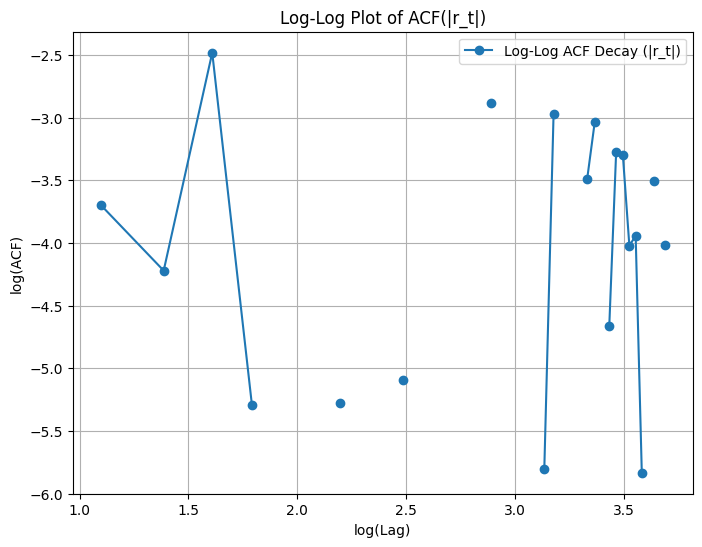

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

abs_returns2 = np.abs(returns2)

max_lag = 40
acf_returns2 = []
for serie in returns2:
    acf_values = acf(serie, nlags = max_lag, fft = True)
    acf_returns2.append(acf_values)
    
mean_acf_returns2 = np.mean(acf_returns2, axis= 0)

# Plot mean ACF of r_t
plt.figure(figsize=(12, 6))
plt.plot(range(max_lag + 1), mean_acf_returns2, marker='o', label='Mean ACF of Returns (r_t)')
plt.axhline(0, color='red', linestyle='--')
plt.title('Autocorrelation Function of Returns (r_t)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

# 4. Aggregate ACF for |r_t| (absolute returns)
acf_abs_returns2 = []
for serie in abs_returns2:
    acf_values = acf(serie, nlags=max_lag, fft=True)
    acf_abs_returns2.append(acf_values)

mean_acf_abs_returns2 = np.mean(acf_abs_returns2, axis=0)

# Plot mean ACF of |r_t|
plt.figure(figsize=(12, 6))
plt.plot(range(max_lag + 1), mean_acf_abs_returns2, marker='o', label='Mean ACF of Absolute Returns (|r_t|)')
plt.axhline(0, color='red', linestyle='--')
plt.title('Autocorrelation Function of Absolute Returns (|r_t|)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

# 5. Log-log plot of ACF decay for |r_t|
log_lags = np.log(range(1, max_lag + 1))
log_acf = np.log(mean_acf_abs_returns2[1:])

plt.figure(figsize=(8, 6))
plt.plot(log_lags, log_acf, marker='o', label='Log-Log ACF Decay (|r_t|)')
plt.title('Log-Log Plot of ACF(|r_t|)')
plt.xlabel('log(Lag)')
plt.ylabel('log(ACF)')
plt.grid(True)
plt.legend()
plt.show()

We can see that this model still has the problems as the one before.

# Faits stylisés

1 - Do the artificial data and the reel one have the same mean and variance regarding the returns?

In [44]:
real_series = dict_series['0417.HK']
real_returns = real_series
real_mean = np.mean(real_returns)
real_variance = np.std(real_returns)

print(f"The average of the real data is {real_mean:.6f} and the variance {real_variance:.5f}")

The average of the real data is 0.000239 and the variance 0.02756


In [45]:
fake_data = get_fake_data(gen2, 3, dim_noise)
fake_returns = fake_data
flattened_returns = fake_returns.flatten()
fake_mean = np.mean(flattened_returns)
fake_variance = np.var(flattened_returns)

print(f"The average of the real data is {fake_mean:.6f} and the variance {fake_variance:.5f}")

The average of the real data is 0.007050 and the variance 0.00883


In [46]:
mu_error = np.abs(fake_mean - real_mean) / real_mean * 100
var_error = np.abs(fake_variance - real_variance) / real_variance * 100

print(f"The error of the average is: {mu_error:.2f}% and the error of the variance is {var_error:.2f}%")

The error of the average is: 2854.37% and the error of the variance is 67.96%


So we can say that we were pretty about the average and the variance was closer.

### Activation function

At the of the model, im using a tanh activation function, which is bounded to the values of -1 to 1, which mgight hinder the heavy tail of the distribution, however, the real data never get off the bounds.

The problem of the activation functions like RELU is that it doesnt capture the symmetry of the data, but it also doesnt cant generate strong heavy tails, since is it just a max function, and the values that we supply to this function are generated by a linear combination, so we cannot expect to have values growing unexplectly fast (no heavy tail), but rather to have smooth outputs.

An activation function that might be useful could be the exponential function, or a polynomial activation function. By this way we have a function that is convex and makes the data to diverge into heavier values.

###  Long memory volatility

The tiem series that we just generated didn't have long memory volatility. The ones that could be created with the activation functions previously mentiones, might not create long memory output.



### Probability by the discriminator that the real value are real

C:\Users\Marti\AppData\Local\Temp\ipykernel_42664\533692878.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  windows = torch.tensor(windows, dtype=torch.float32)


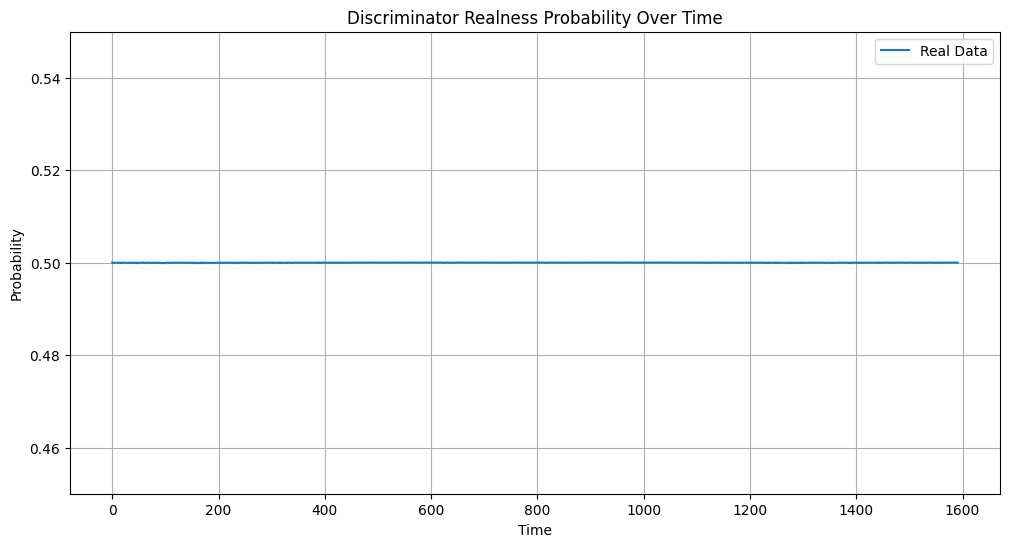

In [47]:
stride = 1
T = 252

def sliding_window (data, window_size, stride):
    n_windows = (len(data) - window_size) // stride + 1
    windows = np.array([data[i:i + window_size] for i in range(0, n_windows * stride, stride)])
    windows = torch.from_numpy(windows).to(device)
    windows = torch.tensor(windows, dtype=torch.float32)
    return windows

real_data = dict_series['0417.HK']
data_sliced = sliding_window(real_data.values, T, stride)
with torch.no_grad(): 
    probabilities = disc2(data_sliced).cpu().numpy()

# Plot probabilities over time
plt.figure(figsize=(12, 6))
plt.plot(probabilities, label='Real Data')
plt.title('Discriminator Realness Probability Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.ylim(0.45, 0.55)
plt.legend()
plt.grid(True)
plt.show()
